In [ ]:
!pip install git+https://github.com/albumentations-team/albumentations.git

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-mjpl6rcf
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-mjpl6rcf
  Created wheel for albumentations: filename=albumentations-1.0.1-cp37-none-any.whl size=98544 sha256=0e46700b8b9edcfb784ff4799cb90e0cb22bc9a8cc9526cf49e6aca722483a3e
  Stored in directory: /tmp/pip-ephem-wheel-cache-hkze3q8_/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
!cd EVA6/A9

In [ ]:
# from __future__ import print_function
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
# import torchvision

# # Let's visualize some of the images
# %matplotlib inline
# import cv2
# import numpy as np
# import albumentations as A
# import matplotlib.pyplot as plt
# from albumentations.pytorch import ToTensorV2
import copy

from tqdm import tqdm 

from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [ ]:
import argparse

from models import *

from utils.transform import Transforms
from utils.graphs_utility import plot_metrics, plot_misclassified
from utils.misc import get_cuda, run_epochs, get_wrong_predictions, load_classes, \
    get_images_lables_for_grad_cam, grad_cam
from utils.data_utility import train_data_transformation, test_data_transformation, \
    download_train_data_cifar10, download_test_data_cifar10, get_data_loader_args, load_test_data_cifar10, load_train_data_cifar10


parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--resume', '-r', action='store_true',
#                     help='resume from checkpoint')
parser.add_argument('--model', default='resnet', help='specify which model to run')
args = parser.parse_args()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print('==> Preparing data..')
train_transforms = Transforms(train_data_transformation()) # Train Data Transformation
test_transforms = Transforms(test_data_transformation()) # Test Data Transformations

train_data = download_train_data_cifar10(train_transforms=train_transforms) # Download Train Data
test_data = download_test_data_cifar10(test_transforms=test_transforms) # Download Test Data

cuda = get_cuda() # Check for cuda
data_loader_args = get_data_loader_args(cuda) # Data Loader Arguments

train_loader = load_train_data_cifar10(train_data, **data_loader_args) # Load Train Data
test_loader = load_test_data_cifar10(test_data, **data_loader_args) # Load Test Data

device = torch.device("cuda" if cuda else "cpu")


In [ ]:
print('==> Building model..')
model = ResNet18()
model = model.to(device)



In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = resnet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
SEED = 42

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


One cycle LR

In [ ]:
from utils.cyclic_LR import cyclic_lr

In [ ]:
def imshow(img,c ):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(7,7))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)

In [ ]:
def show_train_data(dataset):
  dataiter = iter(dataset)
  images, labels = dataiter.next()
  for i in range(10):
    index = [j for j in range(len(labels)) if labels[j] == i]
    imshow(torchvision.utils.make_grid(images[index[0:5]],nrow=5,padding=2,scale_each=True))

In [ ]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
show_train_data(train_data)

AttributeError: ignored

## Once Cycle Policy


### **Model Design**

### **Model Summary**

### **Train Function**

### **Test Function**

### **Train And Test the Model**

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)
scheduler = OneCycleLR(optimizer, max_lr = 0.0105  , total_steps=None, epochs=24, steps_per_epoch=len(train_loader), pct_start=0.167, anneal_strategy='linear', 
                       cycle_momentum=False, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =1)

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
LR = []
for epoch in range(1, 25):
    print("EPOCH:", epoch,'LR:',optimizer.param_groups[0]['lr'])
    LR.append(optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer,scheduler,criterion, train_accuracy, train_losses)

    test(model, device, test_loader,test_accuracy, test_losses)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.0010500000000000002


Loss=1.3445355892181396 Batch_id=97 Accuracy=38.41: 100%|██████████| 98/98 [00:22<00:00,  4.40it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 26693/50000 (53.39%)

EPOCH: 2 LR: 0.0034138025034202517


Loss=1.1088805198669434 Batch_id=97 Accuracy=57.69: 100%|██████████| 98/98 [00:22<00:00,  4.38it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 32963/50000 (65.93%)

EPOCH: 3 LR: 0.005777605006840504


Loss=0.9029841423034668 Batch_id=97 Accuracy=64.54: 100%|██████████| 98/98 [00:22<00:00,  4.29it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 31004/50000 (62.01%)

EPOCH: 4 LR: 0.008141407510260755


Loss=0.8154078722000122 Batch_id=97 Accuracy=70.23: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 36633/50000 (73.27%)

EPOCH: 5 LR: 0.010498958154690449


Loss=0.7859584093093872 Batch_id=97 Accuracy=73.92: 100%|██████████| 98/98 [00:23<00:00,  4.19it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 39054/50000 (78.11%)

EPOCH: 6 LR: 0.010026269079060197


Loss=0.5612255930900574 Batch_id=97 Accuracy=78.92: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 40906/50000 (81.81%)

EPOCH: 7 LR: 0.009553580003429945


Loss=0.5114068388938904 Batch_id=97 Accuracy=81.23: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 42542/50000 (85.08%)

EPOCH: 8 LR: 0.009080890927799692


Loss=0.47934818267822266 Batch_id=97 Accuracy=83.75: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 44083/50000 (88.17%)

EPOCH: 9 LR: 0.00860820185216944


Loss=0.39853644371032715 Batch_id=97 Accuracy=85.97: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 45098/50000 (90.20%)

EPOCH: 10 LR: 0.008135512776539188


Loss=0.48269256949424744 Batch_id=97 Accuracy=87.86: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 45174/50000 (90.35%)

EPOCH: 11 LR: 0.007662823700908936


Loss=0.34325504302978516 Batch_id=97 Accuracy=88.86: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 45378/50000 (90.76%)

EPOCH: 12 LR: 0.007190134625278684


Loss=0.29835012555122375 Batch_id=97 Accuracy=90.39: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 46469/50000 (92.94%)

EPOCH: 13 LR: 0.006717445549648432


Loss=0.2676571011543274 Batch_id=97 Accuracy=91.44: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 47453/50000 (94.91%)

EPOCH: 14 LR: 0.0062447564740181795


Loss=0.2054731696844101 Batch_id=97 Accuracy=92.44: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 47863/50000 (95.73%)

EPOCH: 15 LR: 0.005772067398387927


Loss=0.22708427906036377 Batch_id=97 Accuracy=93.32: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 47940/50000 (95.88%)

EPOCH: 16 LR: 0.005299378322757676


Loss=0.14688341319561005 Batch_id=97 Accuracy=93.68: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 47989/50000 (95.98%)

EPOCH: 17 LR: 0.004826689247127424


Loss=0.1678714007139206 Batch_id=97 Accuracy=94.28: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 48588/50000 (97.18%)

EPOCH: 18 LR: 0.004354000171497172


Loss=0.1120087057352066 Batch_id=97 Accuracy=94.82: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 48451/50000 (96.90%)

EPOCH: 19 LR: 0.0038813110958669196


Loss=0.1567453145980835 Batch_id=97 Accuracy=95.49: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 49039/50000 (98.08%)

EPOCH: 20 LR: 0.0034086220202366665


Loss=0.14624282717704773 Batch_id=97 Accuracy=96.02: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 49023/50000 (98.05%)

EPOCH: 21 LR: 0.0029359329446064144


Loss=0.1643918752670288 Batch_id=97 Accuracy=96.31: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 49389/50000 (98.78%)

EPOCH: 22 LR: 0.0024632438689761622


Loss=0.1308669149875641 Batch_id=97 Accuracy=96.76: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 49580/50000 (99.16%)

EPOCH: 23 LR: 0.00199055479334591


Loss=0.1570596843957901 Batch_id=97 Accuracy=97.09: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Accuracy: 49644/50000 (99.29%)

EPOCH: 24 LR: 0.001517865717715658


Loss=0.09870411455631256 Batch_id=97 Accuracy=97.33: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]



Test set: Average loss: 0.0001, Accuracy: 49664/50000 (99.33%)



### **Train, Validation Loss and Accuracy Plots**

In [ ]:
LR

[0.0010500000000000002,
 0.0034138025034202517,
 0.005777605006840504,
 0.008141407510260755,
 0.010498958154690449,
 0.010026269079060197,
 0.009553580003429945,
 0.009080890927799692,
 0.00860820185216944,
 0.008135512776539188,
 0.007662823700908936,
 0.007190134625278684,
 0.006717445549648432,
 0.0062447564740181795,
 0.005772067398387927,
 0.005299378322757676,
 0.004826689247127424,
 0.004354000171497172,
 0.0038813110958669196,
 0.0034086220202366665,
 0.0029359329446064144,
 0.0024632438689761622,
 0.00199055479334591,
 0.001517865717715658]

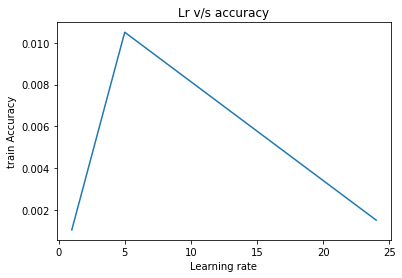

In [ ]:
plt.plot(np.arange(1,25),LR)
plt.ylabel('train Accuracy')
plt.xlabel("Learning rate")
plt.title("Lr v/s accuracy")
plt.show()

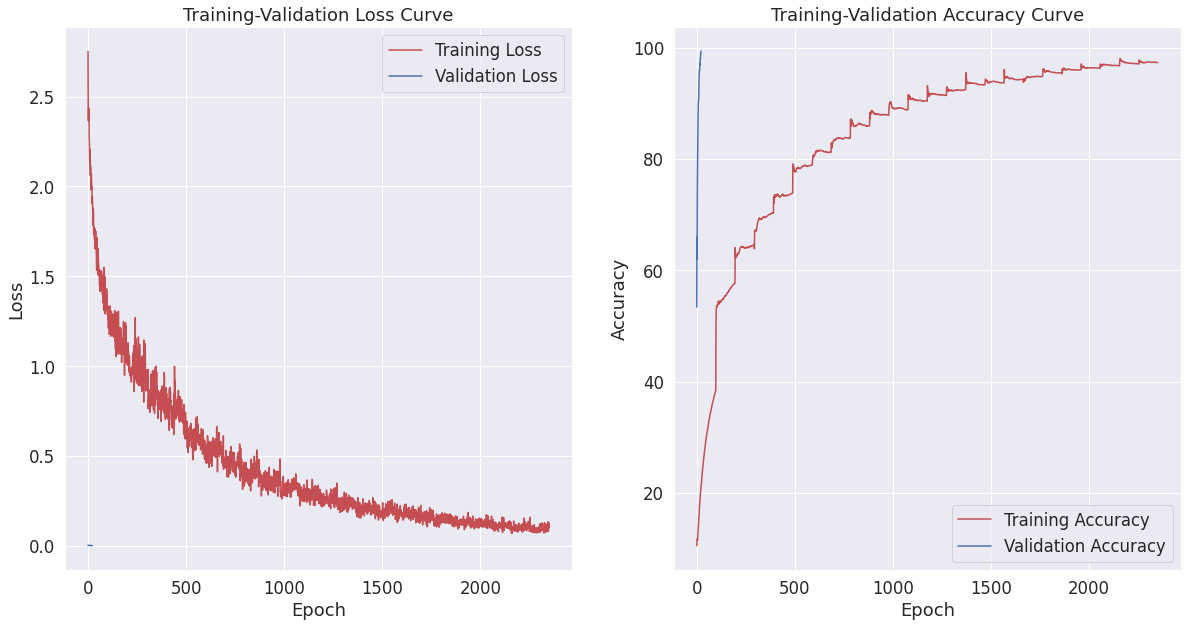

In [ ]:
import seaborn as sns

sns.set(style='whitegrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

# Plot the learning curve.
fig, (plt1,plt2) = plt.subplots(1,2)
plt1.plot(train_losses, 'r', label="Training Loss")
plt1.plot(test_losses, 'b', label="Validation Loss")
plt2.plot(train_accuracy, 'r', label="Training Accuracy")
plt2.plot(test_accuracy, 'b', label="Validation Accuracy")

plt2.set_title("Training-Validation Accuracy Curve")
plt2.set_xlabel("Epoch")
plt2.set_ylabel("Accuracy")
plt2.legend()
plt1.set_title("Training-Validation Loss Curve")
plt1.set_xlabel("Epoch")
plt1.set_ylabel("Loss")
plt1.legend()

plt.show()

### **Classwise Predictions**

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images["image"].to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 92 %
Accuracy of  deer : 100 %
Accuracy of   dog : 97 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %


In [ ]:
wrong_images = []
wrong_label = []
correct_label = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data["image"].to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True).squeeze()

        wrong_pred = (pred.eq(target.view_as(pred)) == False)
        wrong_images.append(data[wrong_pred])
        wrong_label.append(pred[wrong_pred])
        correct_label.append(target.view_as(pred)[wrong_pred])

        wrong_predictions = list(zip(torch.cat(wrong_images), torch.cat(wrong_label), torch.cat(correct_label)))
    print(f'Total wrong predictions are {len(wrong_predictions)}')

Total wrong predictions are 336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

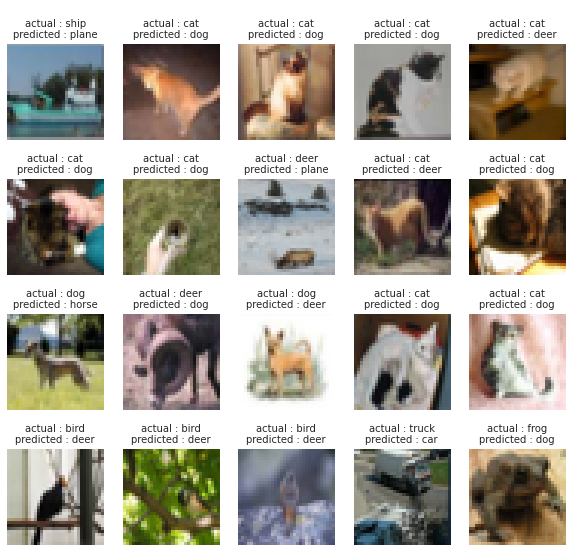

In [ ]:
fig = plt.figure(figsize=(10, 12))
fig.tight_layout()

mean = (0.49139968, 0.48215841, 0.44653091)
std = (0.24703223, 0.24348513, 0.26158784)

for i, (img, pred, correct) in enumerate(wrong_predictions[:20]):
    img, pred, target = img.cpu().numpy().astype(dtype=np.float32), pred.cpu(), correct.cpu()
    for j in range(img.shape[0]):
        img[j] = (img[j] * std[j]) + mean[j]

    img = np.transpose(img, (1, 2, 0))  # / 2 + 0.5
    ax = fig.add_subplot(5, 5, i + 1)
    ax.axis('off')
    ax.set_title(f'\nactual : {classes[target.item()]}\npredicted : {classes[pred.item()]}',
                  fontsize=10)
    ax.imshow(img)

plt.show()